In the model 
$$y\sim N(X\beta,\sigma^2I)$$
$$\beta|\gamma\sim N(0,D_\gamma)$$
where $$D_\gamma = diag((1-\gamma_j)\sigma_0^2 + \gamma_j\sigma^2_1)$$
$$p(\gamma_j = 1) = \pi_1$$
$$\sigma^2\sim IG(a,b)$$

The SSVS iteratively samples:

1. 
$$\beta\sim N(\frac{A}{\sigma^2} X^T y, A)$$ 
where 
$$A = (X^TX/\sigma^2 + D_\gamma^{-1})^{-1}$$

2. $$\sigma^2\sim IG(n/2 + a, ||y-X\beta||^2/2 + b)$$

3. $$p(\gamma_j = 1) = \frac{p_1}{p_0+p_1}$$
 where 

 $$p_1 = \pi_1 p(\beta|\gamma_j=1,\gamma_{-j})$$
 $$p_0 = \pi_0 p(\beta|\gamma_j=0,\gamma_{-j})$$



In [167]:
import numpy as np
from scipy.stats import invgamma  
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
def ssvs(X,y,pi0,var0,var1,ig_a=0.01,ig_b=0.01,n_burnin=500,n_post=10000,printevery = 10):
    n,p = X.shape
    XtX = np.dot(X.T,X)
    Xty = np.dot(X.T,y)
    beta_draws = np.zeros((n_burnin + n_post,p))
    gamma_draws = np.zeros((n_burnin + n_post,p))
    sigma2_draws = np.zeros(n_burnin + n_post)
    gamma = np.zeros(p)
    y = np.squeeze(y)
    sigma2 = np.var(y)
    
    for i in range(n_burnin + n_post):
        if(i%printevery==0):
            print(' '.join(['drawing sample',str(i)]))
        # sample beta
        d_inv = 1/(gamma*var1 + (1-gamma)*var0)
        A = np.linalg.inv(XtX/sigma2 + np.diag(d_inv))
        beta = np.random.multivariate_normal(np.squeeze(np.matmul(A/sigma2,Xty)),A)
        sigma2 = invgamma.rvs(a=n/2+ig_a,scale=sum((y-np.matmul(X,beta))**2)/2+ig_b)
        for j in range(p):
            d1 = (gamma*var1 + (1-gamma)*var0)
            d1[j] = var1
            d0 = (gamma*var1 + (1-gamma)*var0)
            d0[j] = var0
            p1 = (1-pi0) * multivariate_normal.pdf(beta, mean=np.zeros(p), cov=np.diag(d1))
            p0 = pi0 * multivariate_normal.pdf(beta, mean=np.zeros(p), cov=np.diag(d0))
            gamma[j] = bernoulli.rvs(p1/(p1+p0), size=1)
        beta_draws[i,:] = beta
        gamma_draws[i,:] = gamma
        sigma2_draws[i] = sigma2
    return {'beta':beta_draws[n_burnin:,:],'gamma':gamma_draws[n_burnin:,:],'sigma2':sigma2_draws[n_burnin:]}
        


In [170]:
np.prod(norm.pdf([0.001, 0.5, 0.999],loc=[1,2,3]))

0.0016903551915525242

In [171]:
multivariate_normal.pdf(x=[0.001, 0.5, 0.999],mean=[1,2,3],cov=np.ones(3))

0.001690355191552525

In [182]:
def ssvs_I_fast(y,pi0,var0,var1,ig_a=0.01,ig_b=0.01,n_burnin=500,n_post=10000,printevery = 10):
    n = y.shape[0]
    p = n
    #n,p = X.shape
    #XtX = np.dot(X.T,X)
    #Xty = np.dot(X.T,y)
    beta_draws = np.zeros((n_burnin + n_post,p))
    gamma_draws = np.zeros((n_burnin + n_post,p))
    sigma2_draws = np.zeros(n_burnin + n_post)
    gamma = np.zeros(p)
    y = np.squeeze(y)
    sigma2 = np.var(y)
    
    for i in range(n_burnin + n_post):
        if(i%printevery==0):
            print(' '.join(['drawing sample',str(i)]))
        # sample beta
        d_inv = 1/(gamma*var1 + (1-gamma)*var0)
        # A = np.linalg.inv(XtX/sigma2 + np.diag(d_inv))
        A = 1/(1/sigma2 + d_inv)
        beta = np.random.normal(A*y/sigma2,np.sqrt(A))
        sigma2 = invgamma.rvs(a=n/2+ig_a,scale=sum((y-beta)**2)/2+ig_b)
        for j in range(p):
            d1 = (gamma*var1 + (1-gamma)*var0)
            d1[j] = var1
            p1 = (1-pi0) * np.prod(norm.pdf(beta, loc=0, scale=np.sqrt(d1)))
            
            d1[j] = var0
            p0 = pi0 * np.prod(norm.pdf(beta, loc=0, scale=np.sqrt(d1)))
            
            gamma[j] = bernoulli.rvs(p1/(p1+p0), size=1)
        beta_draws[i,:] = beta
        gamma_draws[i,:] = gamma
        sigma2_draws[i] = sigma2
    return {'beta':beta_draws[n_burnin:,:],'gamma':gamma_draws[n_burnin:,:],'sigma2':sigma2_draws[n_burnin:]}
        

In [221]:
def gen_data(n,p,pi0,var0,var1,sigma2,XI = True):
    beta0 = np.random.normal(0,np.sqrt(var0),p)
    beta1 = np.random.normal(0,np.sqrt(var1),p)
    gamma = bernoulli.rvs(1-pi0, size=p)
    beta = beta1 * gamma + (1-gamma) * beta0
    if XI:
        y = beta + np.random.normal(0,np.sqrt(sigma2),p)
        return {'beta':beta,'y':y,'X':np.diag(np.ones(p)),'gamma':gamma}
    else:
        X = np.random.normal(size=(n,p))
        beta = np.reshape(beta,(p,1))
        y = np.matmul(X,beta) + np.reshape(np.random.normal(0,np.sqrt(sigma2),n),(n,1))
        return {'beta':np.squeeze(beta),'y':np.squeeze(y),'X':X,'gamma':gamma}

## Dense Design matrix

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


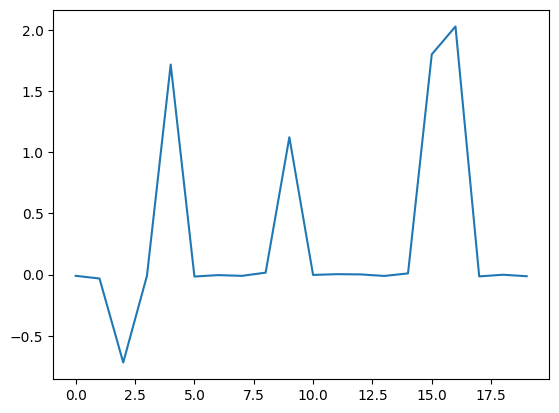

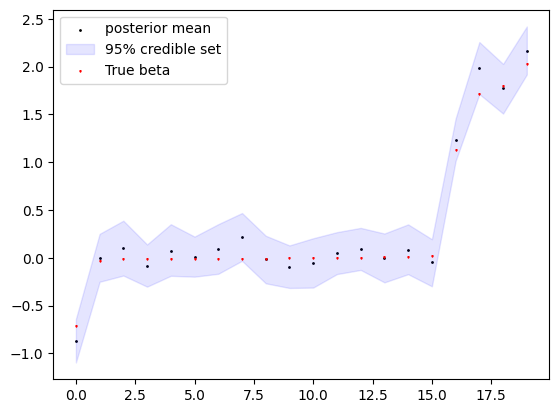

In [226]:
n = 100
p = 20
pi0 = 0.8
var0 = 1e-4
var1 = 4
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=False)
plt.plot(datax['beta'])

fit = ssvs(datax['X'],datax['y'],pi0,var1,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)

upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


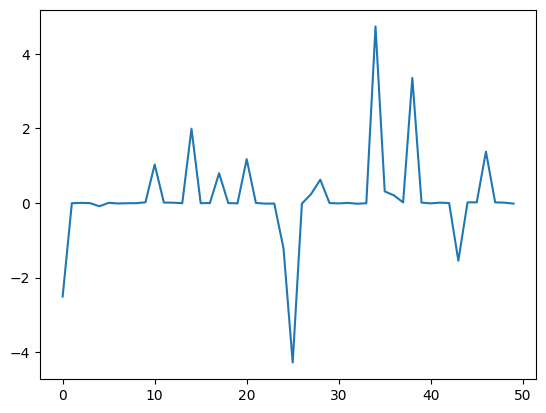

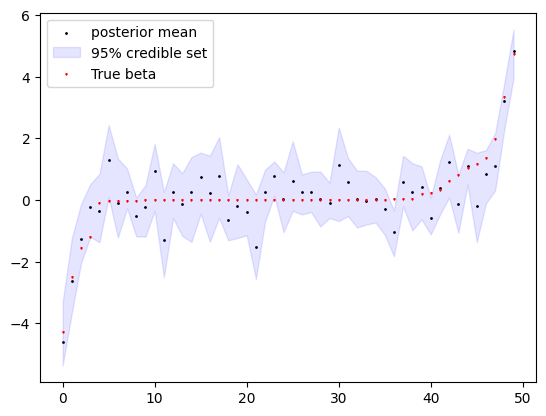

In [227]:
n = 50
p = 50
pi0 = 0.8
var0 = 1e-4
var1 = 4
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=False)
plt.plot(datax['beta'])

fit = ssvs(datax['X'],datax['y'],pi0,var1,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)

upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


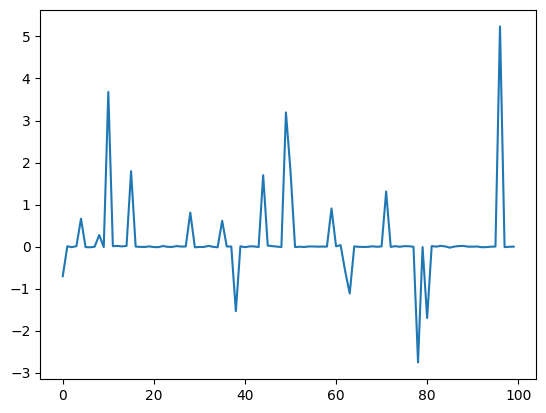

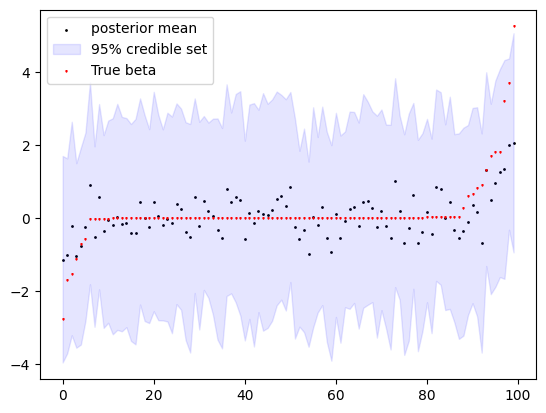

In [230]:
n = 50
p = 100
pi0 = 0.8
var0 = 1e-4
var1 = 4
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=False)
plt.plot(datax['beta'])

fit = ssvs(datax['X'],datax['y'],pi0,var1,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)

upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

## Diagonal Design matrix

We set $\pi_0=0.95,\sigma^2_0 = 0.1,\sigma^2_1 = 5,\sigma^2 = 1$

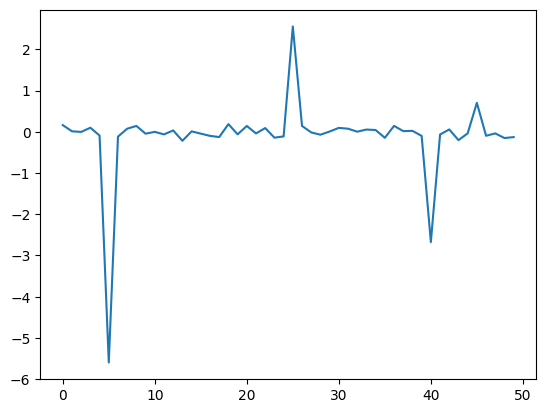

In [186]:
n = 50
p = n
pi0 = 0.95
var0 = 0.01
var1 = 5
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)
plt.plot(datax['beta'])

In [187]:
fit = ssvs_I_fast(datax['y'],pi0,var1,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


In [188]:
upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

,true_beta,ols,posterior_mean,lower,upper
0,0.164322,0.093003,0.079746,-0.765460,0.860263
1,0.014102,0.166995,0.165912,-0.635502,0.975226
2,-0.001225,-0.299560,-0.293510,-1.090976,0.518438
3,0.100943,0.503138,0.494603,-0.279551,1.259186
4,-0.089047,-1.329829,-1.293954,-2.069609,-0.470549
5,-5.596487,-5.636166,-5.480931,-6.142137,-4.364464
6,-0.115264,-1.835827,-1.786202,-2.509163,-0.923798
7,0.076854,0.472299,0.457648,-0.293527,1.217707
8,0.144298,-1.489975,-1.454769,-2.184444,-0.616858
9,-0.044186,-0.233448,-0.224206,-0.992009,0.596712


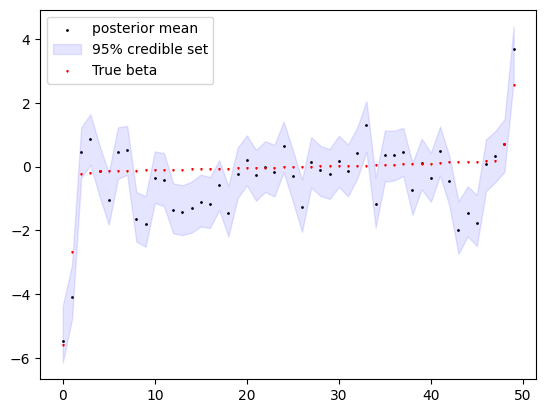

In [207]:
idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

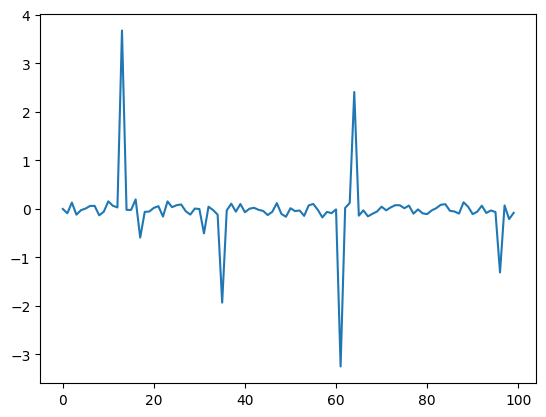

In [208]:
n = 100
p = n
pi0 = 0.95
var0 = 0.01
var1 = 5
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)
plt.plot(datax['beta'])


In [209]:
fit = ssvs_I_fast(datax['y'],pi0,var1,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


In [210]:
upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

,true_beta,ols,posterior_mean,lower,upper
0,-0.003888,1.943498,1.916111,1.270247,2.483806
1,-0.093082,-0.541143,-0.528155,-1.092850,0.102069
2,0.126485,1.464765,1.444282,0.858019,1.995306
3,-0.122199,-2.756626,-2.712692,-3.279233,-2.048587
4,-0.029584,0.735844,0.724641,0.123030,1.321939
...,...,...,...,...,...
95,-0.067531,-1.516098,-1.489047,-2.043182,-0.888588
96,-1.313577,-1.553560,-1.529279,-2.109594,-0.892016
97,0.068612,0.948301,0.934175,0.315412,1.514232
98,-0.213216,0.909829,0.894528,0.255996,1.502139


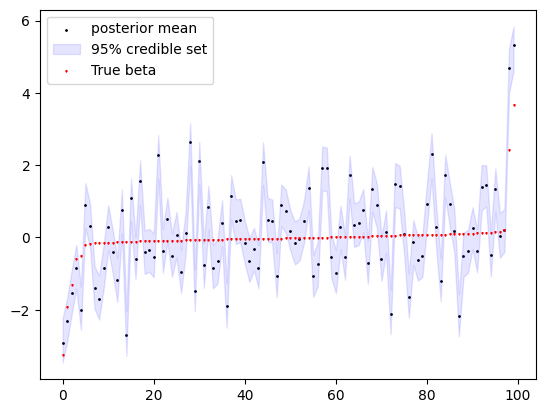

In [211]:
idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000


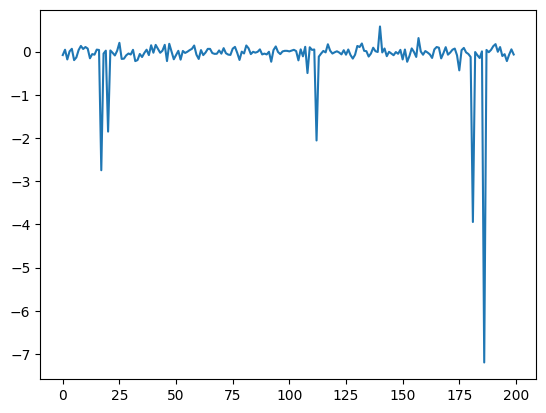

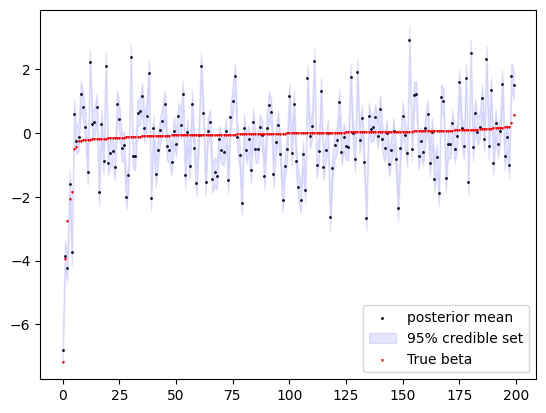

In [213]:
n = 200
p = n
pi0 = 0.95
var0 = 0.01
var1 = 5
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)
plt.plot(datax['beta'])

fit = ssvs_I_fast(datax['y'],pi0,var1,var1,
ig_a=0.01,ig_b=0.01,n_burnin=1000,
n_post=5000,
printevery = 1000)

upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

drawing sample 0
drawing sample 1000
drawing sample 2000
drawing sample 3000
drawing sample 4000
drawing sample 5000
drawing sample 6000
drawing sample 7000
drawing sample 8000
drawing sample 9000
drawing sample 10000
drawing sample 11000
drawing sample 12000
drawing sample 13000
drawing sample 14000
drawing sample 15000
drawing sample 16000
drawing sample 17000
drawing sample 18000
drawing sample 19000


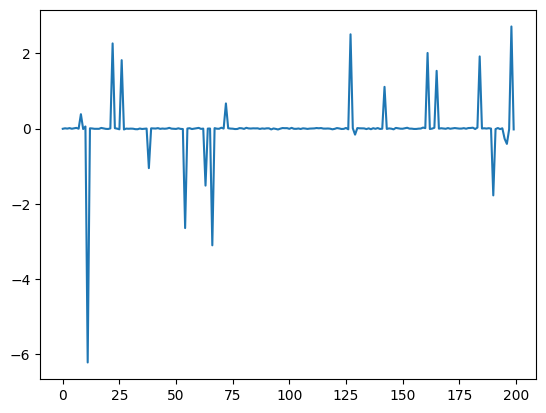

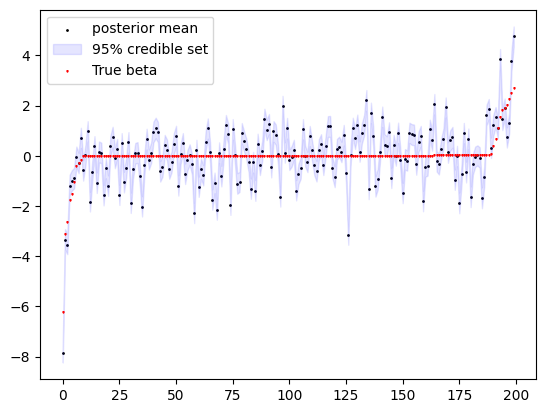

In [231]:
n = 200
p = n
pi0 = 0.9
var0 = 1e-4
var1 = 5
sigma2 = 1
datax = gen_data(n,p,pi0,var0,var1,sigma2,XI=True)
plt.plot(datax['beta'])

fit = ssvs_I_fast(datax['y'],pi0,var1,var1,
ig_a=0.01,ig_b=0.01,n_burnin=5000,
n_post=15000,
printevery = 1000)

upper_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.975)
lower_ci = np.apply_along_axis(np.quantile,0,fit['beta'],q=0.025)
pm = np.apply_along_axis(np.mean,0,fit['beta'])
res = pd.DataFrame({'true_beta':np.squeeze(datax['beta']),
'ols': np.squeeze(np.matmul(np.linalg.inv(np.matmul(datax['X'].T,datax['X'])),np.matmul(datax['X'].T,datax['y']))),
'posterior_mean':pm,
'lower':lower_ci,
'upper':upper_ci})
res

idx = [i for i in range(p)]
order_idx = np.argsort(datax['beta'])
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])

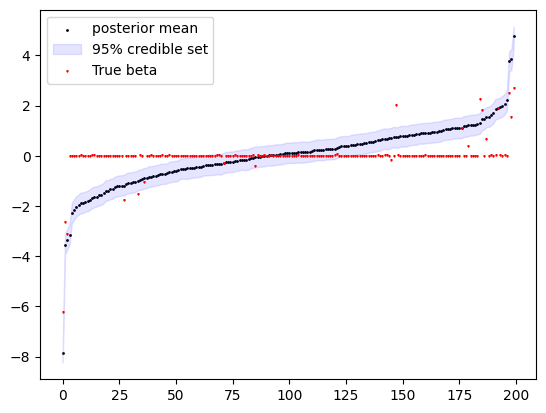

In [232]:
idx = [i for i in range(p)]
order_idx = np.argsort(pm)
fig, ax = plt.subplots()
ax.scatter(idx,pm[order_idx],s=1,color='black')
ax.fill_between(idx,(lower_ci)[order_idx], (upper_ci)[order_idx], color='b', alpha=.1)
ax.scatter(idx,datax['beta'][order_idx],s=0.8,color='red',marker='v')
ax.legend(['posterior mean','95% credible set','True beta'])